# Visualizing ENACT Outputs
This notebook was adapted from the Sanofi-enact repository:
https://github.com/Sanofi-Public/enact-pipeline/tree/main
It is intended to be used on the ENACt outputs after the sushi app was ran.
To start, just paste the link to the output data folder into `output_link`

This notebook provides a comprehensive, step-by-step guide on how to access and analyze output data from ENACT.

## TissUUmaps
Alternatively, you can use the TissUUmpas browser. Enact automatically generated the required project files so after installing on your device you can simply open the project files (saved to the tmap folder)
https://tissuumaps.github.io/TissUUmaps-docs/docs/intro/about.html


## Install required packages 

Use the tmp_enact_analysis environment for analysis

## Import Required Libraries

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import scanpy as sc
from PIL import Image
import tifffile as tifi
from IPython.display import IFrame
from datetime import datetime
import os
from shapely import wkt

## Locate the output files
Replace the following paths with your file paths

`output_link`= navigate to the sushi output dataset generated by the enact app, right-click on the data folder button and copy the link

In [35]:
output_link = "https://fgcz-sushi.uzh.ch//projects/p1001/EzPyzENACTApp_2025-07-07--09-44-09/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/"
# Anndata object path
if "https://fgcz-sushi.uzh.ch/" in output_link:
    output_path = output_link.replace("https://fgcz-sushi.uzh.ch/", "/srv/gstore/")
else:
    output_path = output_link.replace("https://fgcz-gstore.uzh.ch/", "/srv/gstore/")
cells_adata_path = f"{output_path}/tmap/weighted_by_area|celltypist_cells_adata.h5"
polygons_enact = f"{output_path}/cells_df.csv"

# Cropped whole slide image
wsi_path = f"{output_path}/tmap/wsi.tif"

# Cell boundaries image
cells_layer_path = f"{output_path}/tmap/cells_layer.png"

## Loading the AnnData object in Python
Learn how to load the main data structure for single-cell analysis.

In [36]:
# Loading Anndata object
adata = sc.read_h5ad(cells_adata_path)
adata

AnnData object with n_obs × n_vars = 164287 × 18085
    obs: 'cell_type', 'patch_id'
    obsm: 'spatial', 'stats'

## Getting cell types
Anndata 'obs' entry contains the following information about the cell:
- 'cell_type' column: type assigned to each cell
- 'patch_id' column: the parent patch/ chunk the cell belongs to

In [37]:
adata.obs

cell_type       patch_id
id                                                 
ID_1                 cd4_em/effector  patch_2_0.csv
ID_1021               secretory_club  patch_2_0.csv
ID_1022               secretory_club  patch_2_0.csv
ID_1023               secretory_club  patch_2_0.csv
ID_1028               secretory_club  patch_2_0.csv
...                              ...            ...
ID_124067             macro_alveolar  patch_0_6.csv
ID_124068  endothelia_vascular_cap_g  patch_0_6.csv
ID_124073             macro_alveolar  patch_0_6.csv
ID_124074             macro_alveolar  patch_0_6.csv
ID_124075             macro_alveolar  patch_0_6.csv

[164287 rows x 2 columns]

In [38]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata

AnnData object with n_obs × n_vars = 164287 × 18085
    obs: 'cell_type', 'patch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial', 'stats'

## Getting distribution of cell types 
predicted by the model selected in the enact pipeline

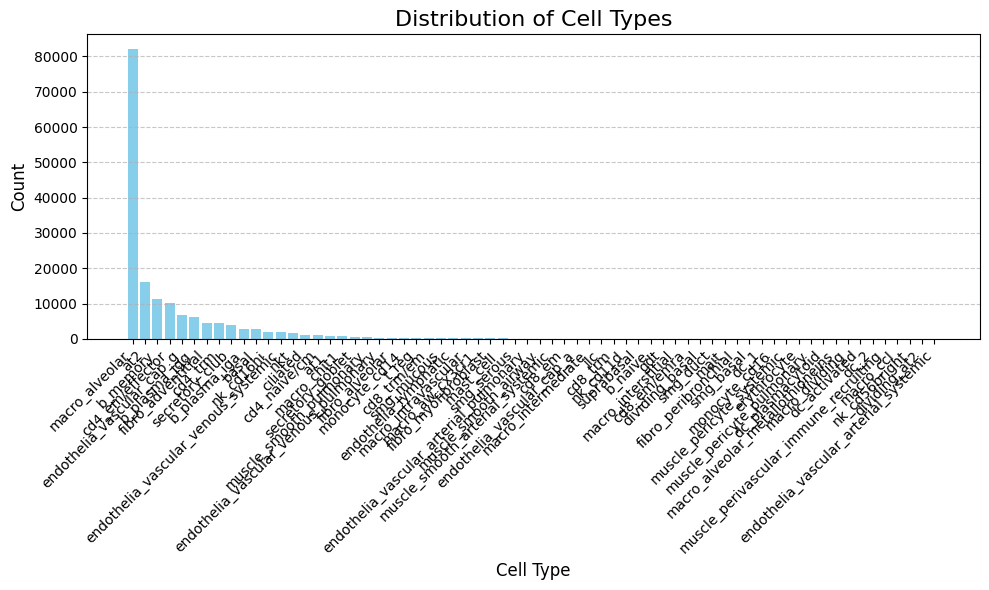

In [39]:
cell_type_counts = adata.obs["cell_type"].value_counts().reset_index()
cell_type_counts.columns = ["Cell Type", "Count"]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(cell_type_counts["Cell Type"], cell_type_counts["Count"], color='skyblue')
plt.title("Distribution of Cell Types", fontsize=16)
plt.xlabel("Cell Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Plotting Cell Stastics

The cell statistics are accessible via adata.obsm["stats"]

In [40]:
adata.obsm["stats"]

num_shared_bins  num_unique_bins  num_transcripts
id                                                          
ID_1                    13               13               40
ID_1021                 18               21              540
ID_1022                 18                4              227
ID_1023                 16                8              187
ID_1028                 15                4              211
...                    ...              ...              ...
ID_124067                0               29               13
ID_124068                4               21               16
ID_124073                8               42               11
ID_124074                4               22                7
ID_124075                6               43                7

[164287 rows x 3 columns]

Plotting number of shared bins per cell, number of unique bins per cell, and number of transcripts per cell.

*Note: In the figures below, each dot is a cell*


1.5 29.5
removed 1565 outliers from a total of 164287 cells
-22.0 58.0
removed 6008 outliers from a total of 164287 cells
-180.0 452.0
removed 12247 outliers from a total of 164287 cells


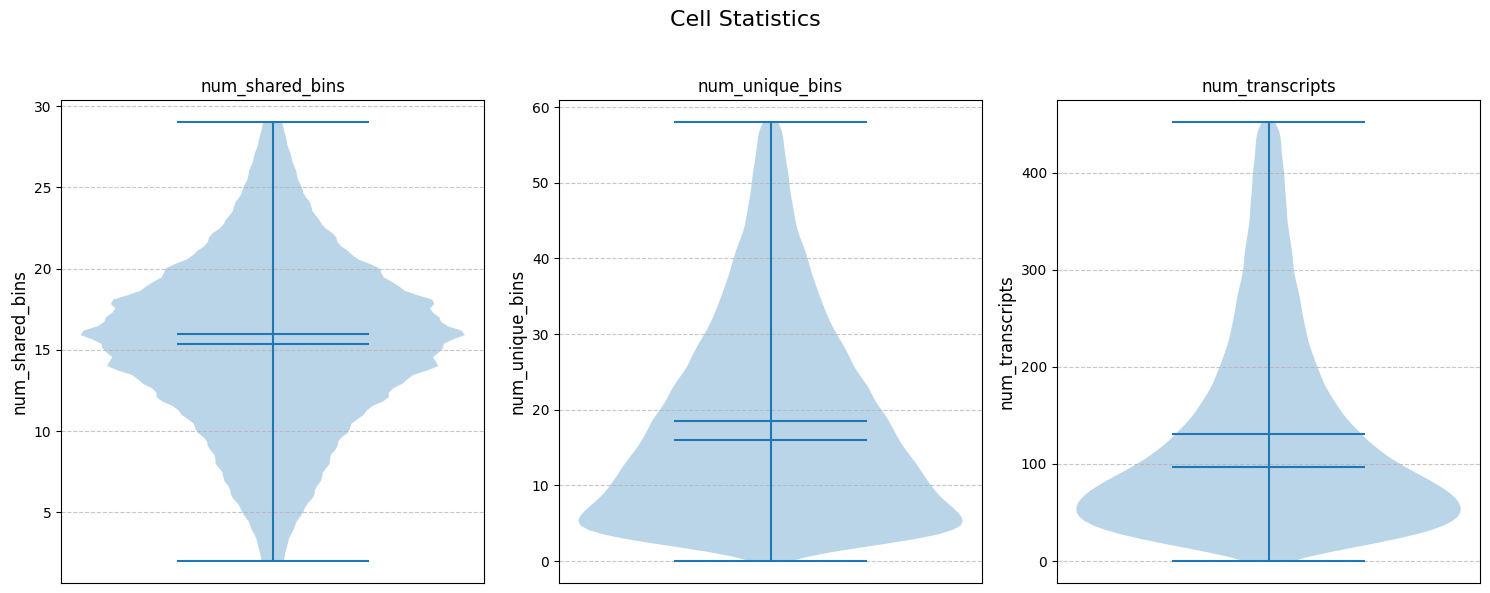

In [41]:
# Extract the stats DataFrame from adata
stats_df = adata.obsm["stats"]

# Function to remove outliers using IQR
def remove_outliers(series):
    q1 = series.quantile(0.25)  # First quartile (25th percentile)
    q3 = series.quantile(0.75)  # Third quartile (75th percentile)
    iqr = q3 - q1  # Interquartile range
    lower_bound = q1 - 1.5 * iqr  # Lower bound (in my examples is always negative so no effect)
    upper_bound = q3 + 1.5 * iqr  # Upper bound
    print(lower_bound, upper_bound)
    print(f"removed {len(series[series >= upper_bound])} outliers from a total of {len(series)} cells")
    return series[(series >= lower_bound) & (series <= upper_bound)]

# Remove outliers from the DataFrame
filtered_stats_df = stats_df.apply(remove_outliers)

# Create subplots: one subplot for each column
num_columns = len(filtered_stats_df.columns)
fig, axes = plt.subplots(1, num_columns, figsize=(15, 6), sharey=False)
for i, column in enumerate(filtered_stats_df.columns):
    axes[i].violinplot(filtered_stats_df[column].dropna(), showmeans=True, showmedians=True)
    axes[i].set_title(column, fontsize=12)
    axes[i].set_xticks([])
    axes[i].grid(axis="y", linestyle="--", alpha=0.7)
    axes[i].set_ylabel(column, fontsize=12)
fig.suptitle("Cell Statistics", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title


# Show the plot
plt.show()

In [42]:
mean_transcripts = adata.obsm["stats"]['num_transcripts'].mean()
median_transcripts = np.median(adata.obsm["stats"]['num_transcripts'])
print(f"Mean transcripts per cell: {mean_transcripts:.2f}")
print(f"Median transcripts per cell: {median_transcripts:.2f}")

Mean transcripts per cell: 169.01
Median transcripts per cell: 106.00


## Getting cell coordinates
Cell centroid coordinates are accessible via adata.obsm["spatial"]

In [43]:
adata.obsm["spatial"]

cell_x  cell_y
id                       
ID_1         8140    3389
ID_1021      8133    2410
ID_1022      8124    2425
ID_1023      8095    2410
ID_1028      8121    2494
...           ...     ...
ID_124067    1396   24067
ID_124068    1441   24040
ID_124073    1673   24024
ID_124074    1657   24072
ID_124075    1621   24018

[164287 rows x 2 columns]

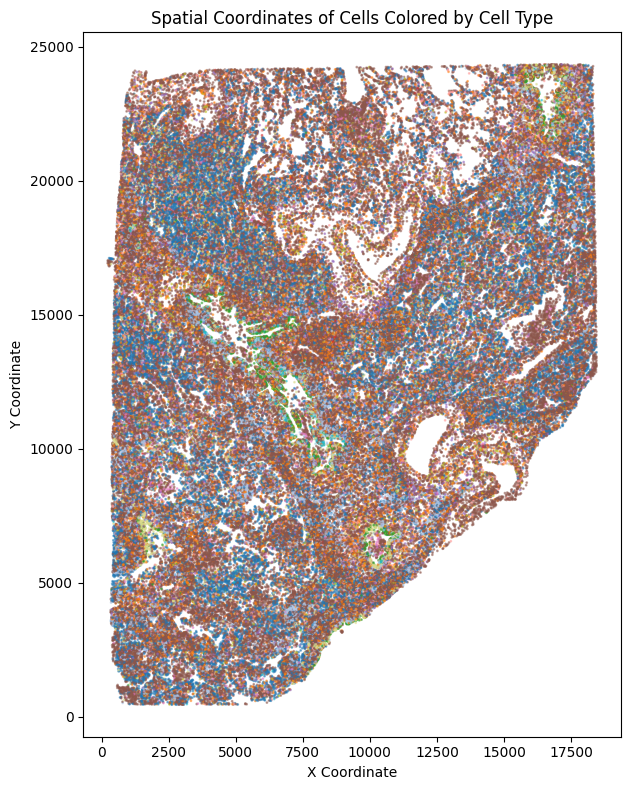

In [44]:
# Extract spatial coordinates and cell types
spatial_coords = adata.obsm["spatial"]
cell_types = adata.obs["cell_type"]

plt.figure(figsize=(18, 8))
scatter = plt.scatter(
    spatial_coords["cell_x"], 
    spatial_coords["cell_y"], 
    c=cell_types.cat.codes, 
    cmap="tab20", 
    s=1, 
    alpha=0.5
)
plt.title("Spatial Coordinates of Cells Colored by Cell Type")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.gca().set_aspect('equal')

# Create a legend with unique cell types
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=ct, 
               markerfacecolor=plt.cm.tab20(i % 20), markersize=6)
    for i, ct in enumerate(cell_types.cat.categories)
]
#plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Cell Type", fontsize=8)
plt.tight_layout()
plt.show()

## Plotting the top-n expressed genes

Plotting the top-n genes by count (summed across all cells)

*Note: ENACT only keeps the top-k highly variable genes in the AnnData object if params>use_hvg is set to True.*

Number of unique genes in the sample: 18085


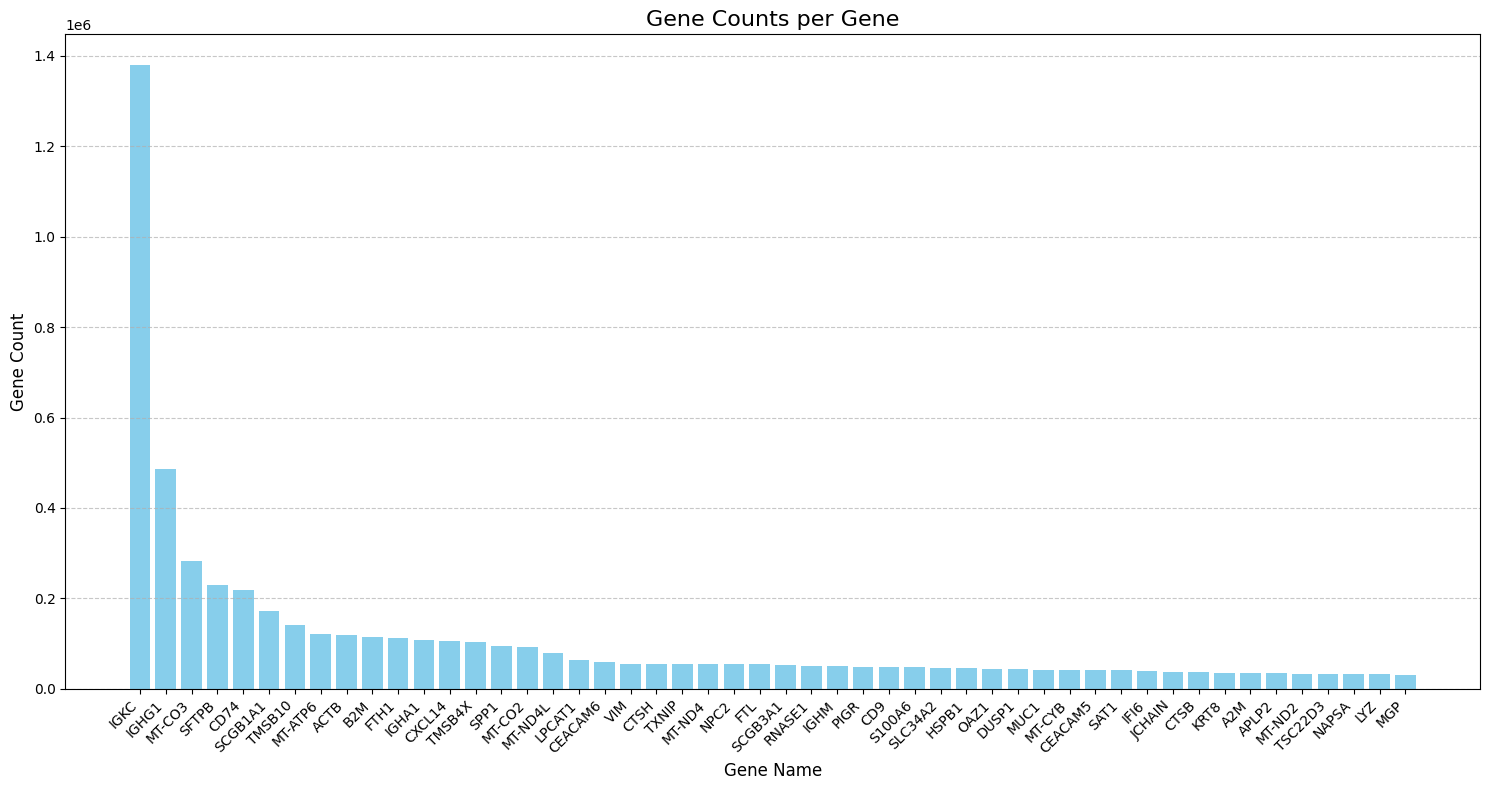

In [45]:
top_n = 50  # Adjust the number of genes to display

# Compute gene counts
counts_per_gene = (
    pd.DataFrame({"Gene Name": adata.var_names, "Gene Count": adata.X.toarray().sum(axis=0)})
    .sort_values(by="Gene Count", ascending=False)
)
print(f"Number of unique genes in the sample: {len(counts_per_gene)}")

# Select the top N genes
top_genes = counts_per_gene[:top_n]

# Create the plot
plt.figure(figsize=(15, 8))
plt.bar(top_genes["Gene Name"], top_genes["Gene Count"], color="skyblue")
plt.title("Gene Counts per Gene", fontsize=16)
plt.xlabel("Gene Name", fontsize=12)
plt.ylabel("Gene Count", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


## Visualizing cell types over the image

Get an image patch to visualize

In [46]:
x_start, y_start = 5000, 3000  # Top-left corner of the patch
patch_size = 1000 # Specify the patch size

Image.MAX_IMAGE_PIXELS = None
wsi_img = tifi.imread(wsi_path)
cells_layer = np.array(Image.open(cells_layer_path))
x_min, x_max, y_min, y_max = (x_start, x_start + patch_size, y_start, y_start + patch_size)
patch = wsi_img[y_min:y_max, x_min:x_max]
patch_boundaries = cells_layer[y_min:y_max, x_min:x_max]


Patch bounds: x_min, x_max, y_min, y_max = (5000, 6000, 3000, 4000)


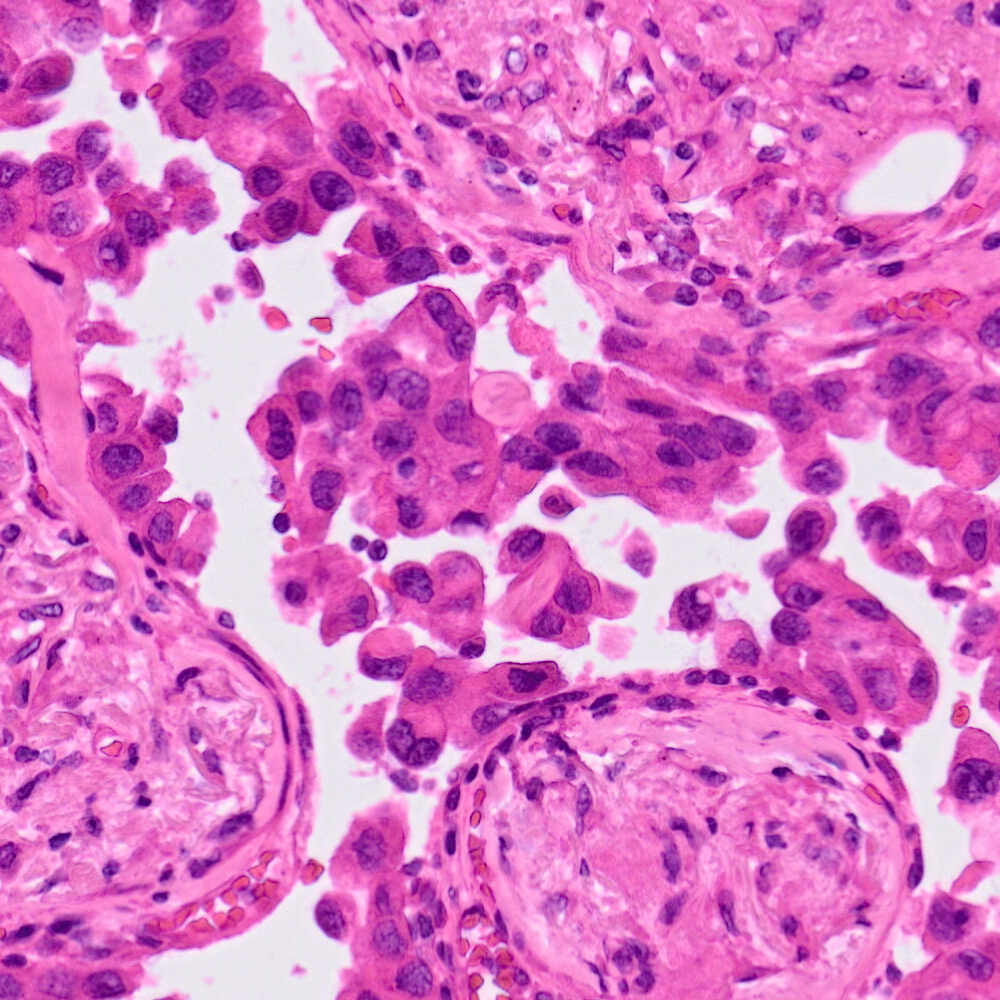

In [47]:
# Convert the NumPy array to a PIL Image
patch_image = Image.fromarray(patch)
print(f"Patch bounds: x_min, x_max, y_min, y_max = {x_min, x_max, y_min, y_max}")
patch_image

Get the cells within a patch and represent their coordinates in the patch frame of reference.

In [48]:
patch_adata = adata[
    adata.obsm["spatial"].cell_x.between(x_min, x_max) & 
    adata.obsm["spatial"].cell_y.between(y_min, y_max)
    ]
patch_cell_coords = patch_adata.obsm["spatial"]
print (f"Number of cells in patch: {patch_cell_coords.shape[0]}")

# Adjust coordinates relative to the patch
patch_cell_coords_df = patch_cell_coords.copy()
patch_cell_coords_df["cell_x_relative"] = patch_cell_coords_df["cell_x"] - x_start
patch_cell_coords_df["cell_y_relative"] = patch_cell_coords_df["cell_y"] - y_start
patch_cell_coords_df["cell_type"] = patch_adata.obs["cell_type"]
patch_cell_coords_df

Number of cells in patch: 451


cell_x  cell_y  cell_x_relative  cell_y_relative  \
id                                                          
ID_1638    5460    3618              460              618   
ID_1639    5168    3523              168              523   
ID_1640    5353    3607              353              607   
ID_1641    5388    3895              388              895   
ID_1642    5385    3651              385              651   
...         ...     ...              ...              ...   
ID_83      5616    3440              616              440   
ID_84      5682    3428              682              428   
ID_85      5660    3408              660              408   
ID_86      5670    3453              670              453   
ID_87      5682    3386              682              386   

                         cell_type  
id                                  
ID_1638  endothelia_vascular_cap_g  
ID_1639  endothelia_vascular_cap_g  
ID_1640             macro_alveolar  
ID_1641                   b_memory  
ID_1642                   b_memory  
...                            ...  
ID_83               macro_alveolar  
ID_84                          at2  
ID_85                          at2  
ID_86                    nk_cd16hi  
ID_87               macro_alveolar  

[451 rows x 5 columns]

Visualize cell segmentation boundaries and cell types within patch

In [49]:
def plot_image_with_cell_overlays(
    patch, 
    patch_boundaries, 
    patch_cell_coords_df, 
    patch_size, 
    alpha=0.4, 
    colormap=plt.cm.tab10
):
    """
    Plots an image patch with overlaid cell coordinates color-coded by cell type.

    Parameters:
        patch (np.ndarray): The base image patch (2D or 3D array).
        patch_boundaries (np.ndarray): The boundary mask image to overlay.
        patch_cell_coords_df (pd.DataFrame): DataFrame with columns 'cell_x_relative', 
                                             'cell_y_relative', and 'cell_type'.
        patch_size (int): The size of the patch (assumes square images).
        alpha (float): Transparency for blending patch and boundaries (0-1).
        colormap: Matplotlib colormap to assign colors to cell types.
    """
    # Normalize images to [0, 1]
    patch_norm = patch / 255.0
    patch_boundaries_norm = patch_boundaries / 255.0

    # Blend the images
    overlay_image = (1 - alpha) * patch_norm + alpha * patch_boundaries_norm

    # Generate colors for unique cell types
    cell_type_colors = {
        cell_type: f"rgb({r*255:.0f}, {g*255:.0f}, {b*255:.0f})"
        for cell_type, (r, g, b) in zip(patch_cell_coords_df["cell_type"].unique(), colormap.colors)
    }

    # Assign colors to each cell type
    patch_cell_coords_df["color"] = patch_cell_coords_df["cell_type"].map(cell_type_colors)

    # Create a Plotly figure
    fig = go.Figure()

    # Add the image as a background
    fig.add_layout_image(
        dict(
            source=Image.fromarray((overlay_image * 255).astype(np.uint8)),  # Convert to PIL image
            x=0,
            y=patch_size,
            xref="x",
            yref="y",
            sizex=patch_size,
            sizey=patch_size,
            xanchor="left",
            yanchor="top",
            layer="below",
        )
    )

    # Add scatter points for the coordinates
    fig.add_trace(
        go.Scatter(
            x=patch_cell_coords_df["cell_x_relative"],
            y=patch_size - patch_cell_coords_df["cell_y_relative"],  # Invert y-axis
            mode="markers",
            marker=dict(
                color=patch_cell_coords_df["color"],  # Color-coding by cell type
                size=10,
            ),
            name="Coordinates",
            hoverinfo='text',
            text=patch_cell_coords_df['cell_type'],  # Hover displays cell type
        )
    )

    # Set axis properties to match the image size and fix zoom alignment
    fig.update_xaxes(
        range=[0, patch_size], 
        visible=False,
        scaleanchor="y",
    )
    fig.update_yaxes(
        range=[0, patch_size], 
        visible=False,
        scaleanchor="x",
    )

    # Update layout to remove padding and ensure consistent scaling
    fig.update_layout(
        title="Image Patch with Cell Overlays",
        height=1000,
        width=1000,
        margin=dict(l=0, r=0, t=0, b=0),  # No margin
    )

    return fig


In [50]:

fig = plot_image_with_cell_overlays(patch, patch_boundaries, patch_cell_coords_df, patch_size)
fig.show()

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
html_file_path = f"sample_enact_output_{timestamp}.html"
fig.write_html(html_file_path)

# Display the HTML file in an iframe
IFrame(src=html_file_path, width='100%', height=600)

[View Interactive Plot](sample_enact_output.html)

Cell segmentation info

In [51]:

enact_cell_polygons = pd.read_csv(polygons_enact)
enact_cell_polygons = enact_cell_polygons.dropna(subset=['geometry'])

enact_cell_polygons["parsed_geometry"] = enact_cell_polygons["geometry"].apply(wkt.loads)
# Convert parsed_geometry to list of arrays with alternating x and y values
enact_cell_polygons["parsed_coordinates"] = enact_cell_polygons["parsed_geometry"].apply(
    lambda geom: np.array(geom.exterior.coords).flatten()
)

enact_polygons = enact_cell_polygons["parsed_coordinates"].to_numpy()

In [52]:
from shapely.geometry import Polygon
enact_polygons = [poly.reshape(-1, 2) for poly in enact_polygons]
# Compute areas in pixels for ENACT and Xenium
enact_areas = [Polygon(poly).area for poly in enact_polygons]

# Mean and median in pixels
enact_mean_area_px = np.mean(enact_areas)
enact_median_area_px = np.median(enact_areas)
print(f"Mean cell area: {enact_mean_area_px:.2f} px, median area: {enact_median_area_px:.2f} px")

# Conversion to um^2 (replace PIXEL_SIZE_UM with your value)
PIXEL_SIZE_UM = 4.7 
enact_mean_area_um2 = enact_mean_area_px / (PIXEL_SIZE_UM ** 2)
enact_median_area_um2 = enact_median_area_px / (PIXEL_SIZE_UM ** 2)

print(f"Mean cell area: {enact_mean_area_um2:.2f} um^2, median area: {enact_median_area_um2:.2f} um^2")

Mean cell area: 1249.97 px, median area: 1052.30 px
Mean cell area: 56.59 um^2, median area: 47.64 um^2


## Plot UMAP, DEG and more
Consider running the EzPyzAnndataReport app on your outputs to obtain further interpretations of the results. 